In [243]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
from dataclasses import dataclass

In [244]:
df = pd.read_csv("/home/max/Documents/Homework/homework/fall-2021/AEM591-Projects/project-2/pulse_discharge_test_data.csv", encoding="iso-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8497 entries, 0 to 8496
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TIME       8497 non-null   object 
 1    "VDC"     8497 non-null   float64
 2    "AMPS"    8497 non-null   float64
 3    "°F"      8497 non-null   float64
 4    "VDC".1   8497 non-null   float64
 5    "AMPS".1  8497 non-null   float64
 6   "°F"       8497 non-null   float64
dtypes: float64(6), object(1)
memory usage: 464.8+ KB


### Fix these column names

In [245]:
r = iter([0, 1])
re_table = str.maketrans(dict.fromkeys(' "'))
df = df.rename({col: col.translate(re_table) if "°F" not in col else col.translate(re_table) + str(next(r)) for col in df.columns}, axis=1)

### Fix the Time Format

In [246]:
start_time = pd.to_datetime(df['TIME'].iloc[0], )

In [247]:
df['t_delta'] = 10
df['t_delta'] = df['t_delta'].cumsum().shift(1).fillna(0)
df['dt'] = df['t_delta'].apply(lambda x: start_time + timedelta(seconds=x))
# df['time'] = df['dt'].dt.hour * 3600 + df['dt'].dt.minute * 60 + df['dt'].dt.second 

In [248]:
#df.set_index('dt', inplace=True, drop=True)
df = df.sort_values('dt', )
df = df.reset_index(drop=True)
df.head()

,TIME,VDC,AMPS,°F0,VDC.1,AMPS.1,°F1,t_delta,dt
0,7:49:26 AM,26.3467,0.012093,83.8055,26.2096,-0.012426,79.4296,0.0,2021-09-23 07:49:26
1,7:49:36 AM,26.3484,0.013611,83.8133,26.2070,-0.011908,79.4368,10.0,2021-09-23 07:49:36
2,7:49:46 AM,26.3477,0.025167,83.7744,26.2091,0.000537,79.3995,20.0,2021-09-23 07:49:46
3,7:49:56 AM,26.3483,0.030908,83.8188,26.2078,0.011945,79.4607,30.0,2021-09-23 07:49:56
4,7:50:06 AM,26.3471,0.028649,83.7770,26.2060,0.001907,79.4264,40.0,2021-09-23 07:50:06


In [249]:
pulse_test_1 = df[['VDC', 'AMPS', '°F0', 't_delta', 'dt']].copy()

### Group the Data into Rest Periods

#### Flag Current Events

In [250]:
def rising_falling():
    COUNT = 0
    def _fn(val):
        nonlocal COUNT
        if val['AMPS'] > 10 and val['AMPS_next'] < 10:
            COUNT += 1
            return COUNT
        elif val['AMPS'] < 10:
            return COUNT
        else:
            return 0
    return _fn

In [252]:
pulse_test_1['AMPS_next'] = pulse_test_1['AMPS'].shift(-1)
pulse_test_1['discharge_event'] = pulse_test_1.apply(rising_falling(), axis=1)
pulse_test_1.drop('AMPS_next', inplace=True, axis=1)
discharge_group_1 = pulse_test_1.groupby('discharge_event')

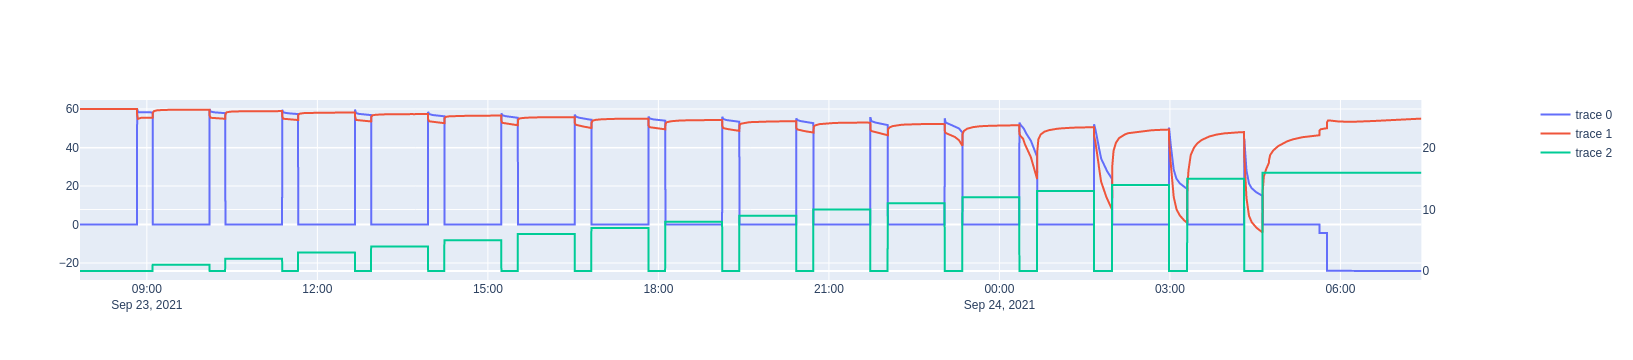

In [254]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=pulse_test_1['dt'],
    y=pulse_test_1['AMPS']
))

fig.add_trace(go.Scatter(
    x=pulse_test_1['dt'],
    y=pulse_test_1['VDC']
),secondary_y=True
             )

fig.add_trace(go.Scatter(
    x=pulse_test_1['dt'],
    y=pulse_test_1['discharge_event']
),secondary_y=True
             )

fig.show()

In [ ]:
pulse_test_2 = df[['VDC.1', 'AMPS.1', '°F1']]

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
#     x=pulse_test_2.index,
    y=pulse_test_2['AMPS.1']
))

fig.add_trace(go.Scatter(
#     x=pulse_test_2.index,
    y=pulse_test_2['VDC.1']
),secondary_y=True
             )
fig.show()

## Partition into Discharge Groups

In [11]:
pulse_test_1['AMPS_next'] = pulse_test_1['AMPS'].shift(-1)
pulse_test_1['discharge_event'] = pulse_test_1.apply(rising_falling(), axis=1)
# pulse_test_1 = pulse_test_1.loc[pulse_test_1['discharge_event'] > 0] 
discharge_group_1 = pulse_test_1.groupby('discharge_event')

In [217]:
@dataclass
class LSHelper:
    i_ts: float
    i_last: float
    t_vect: pd.Series
    v_vect: pd.Series
    v_0: float
    
    def decay_func(self, x):  
        return x[0] - self.i_ts * x[1] + self.i_ts * sum(self._exponent_helper(x[2:]))
    
    def _exponent_helper(self, x_slice):
        return (r * np.exp(-1 * self.t_vect / tau) for r, tau in list(zip(*[iter(x_slice)] * 2)))
    
    def optimizer(self, ):
        def fn(c):
            val = self.v_vect - self.decay_func(c)
            return val
        return fn

    def compute_estimate(self, c):
        return self.decay_func(c) 
    
    def find_time_const(self, ):
        for v, t in zip(self.v_vect, self.t_vect):
            if v > (self.v_0 + .5 * (self.v_vect[-1] - self.v_0)):
                return t
    
    def x_0(self, n):
        return np.array([self.v_vect[-1], (self.v_vect[1] - self.v_vect[0])/ self.i_ts] + [(self.v_vect[-1] - self.v_vect[1])/ self.i_ts, self.t_vect[-1] / 3] * n )
    

In [218]:
group_1 = discharge_group_1.get_group(2)

In [219]:
ls_helper = LSHelper(i_ts=group_1['AMPS'].iloc[0], 
                     i_last = group_1['AMPS'].iloc[-1],
                     t_vect=group_1['t_delta'].diff().fillna(0).cumsum().values, 
                     v_vect=group_1['VDC'].values, 
                     v_0=group_1['VDC'].iloc[0]
                    )

In [114]:
# ls_helper.v_vect 

In [220]:
(ls_helper.v_vect[1] / group_1['AMPS'].iloc[0]) * group_1['AMPS'].iloc[0]

25.496

In [234]:
x0 = ls_helper.x_0(2)
# ls_helper.t_vect
x0

array([2.60064000e+01, 1.27254272e-02, 8.82600628e-03, 1.20000000e+03,
       8.82600628e-03, 1.20000000e+03])

In [240]:
res = least_squares(ls_helper.optimizer(), x0=x0,) # loss='cauchy', f_scale=0.1,)

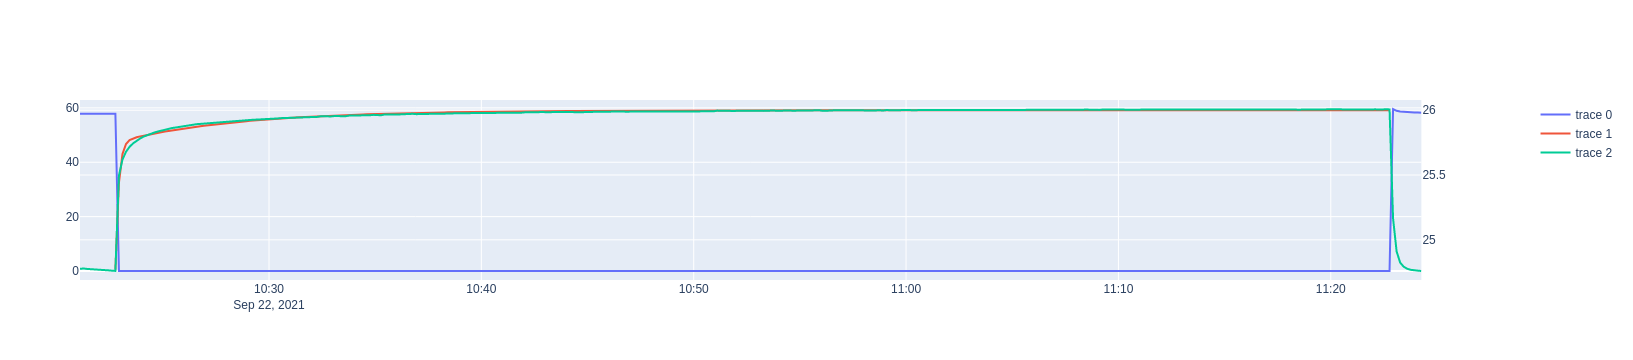

In [241]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=df['dt'].iloc[group_1.index[0] - 10:group_1.index[-1] + 10],
    y=df['AMPS'].iloc[group_1.index[0] - 10:group_1.index[-1] + 10]
))

fig.add_trace(go.Scatter(
        x=group_1['dt'],
        y=ls_helper.compute_estimate(res.x)
        ),
              secondary_y=True
)


fig.add_trace(go.Scatter(
    x=df['dt'].iloc[group_1.index[0] - 10:group_1.index[-1] + 10],
    y=df['VDC'].iloc[group_1.index[0] - 10:group_1.index[-1] + 10],
#     mode="markers+lines"
),secondary_y=True
             )

# fig.update_layout(yaxis2_range=[20, 30])

fig.show()

In [242]:
res.x

array([ 4.49955748e+03,  7.73582416e+01, -1.69767337e-02,  8.95322110e+00,
       -4.26874180e-03,  3.45027463e+02])